<a href="https://colab.research.google.com/github/lucavgn/AML_Project5/blob/main/Project5_centralized_training_LAMB_LARS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile distributed-training.py

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse

# Training settings
epochs = 20 #should be 150 but it takes too much time to run the code
batch_size = 64
momentum = 0.9
weight_decay = 4e-4

# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # First convolutional layer: takes 3 input channels, outputs 64 features, kernel size = 5
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.relu1 = nn.ReLU()  # ReLU activation after first convolution
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel size

        # Second convolutional layer: takes 64 input channels, outputs 64 features, kernel size = 5
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()  # ReLU activation after second convolution
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel size

        # Fully connected layer 1: input = 64 * 5 * 5 (flattened features from previous pooling), output = 384
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.relu3 = nn.ReLU()  # ReLU activation after fully connected layer 1

        # Fully connected layer 2: input = 384, output = 192
        self.fc2 = nn.Linear(384, 192)
        self.relu4 = nn.ReLU()  # ReLU activation after fully connected layer 2

        # Softmax classifier: input = 192, output = 100 (for CIFAR-100 classes)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))  # First convolutional block
        x = self.pool2(self.relu2(self.conv2(x)))  # Second convolutional block
        x = x.view(-1, 64 * 5 * 5)  # Flatten the output from the second convolutional block
        x = self.relu3(self.fc1(x))  # Fully connected layer 1
        x = self.relu4(self.fc2(x))  # Fully connected layer 2
        x = self.fc3(x)  # Final softmax layer for output
        return x

# Load CIFAR-100 dataset
transform = transforms.Compose([transforms.ToTensor(),  # Convert images to PyTorch tensors
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize images to the range [0, 1]

# Dataset for training the model
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Dataset for testing the model
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Command-line arguments
parser = argparse.ArgumentParser(description='Train with Large-Batch Optimizers')
parser.add_argument('--optimizer', type=str, default='SGDM', choices=['SGDM', 'AdamW', 'LARS', 'LAMB'],
                    help='Choose optimizer')
parser.add_argument('--batch-size', type=int, default=64, help='Batch size')
parser.add_argument('--lr', type=float, default=0.01, help='Base learning rate')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGDM and LARS')
parser.add_argument('--weight-decay', type=float, default=4e-4, help='Weight decay')
args = parser.parse_args()

# Optimizer Subclasses
class LARS(optim.Optimizer):
    def __init__(self, params, lr, momentum=0.9, weight_decay=0, trust_coefficient=0.001):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, trust_coefficient=trust_coefficient)
        super(LARS, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['momentum_buffer'] = torch.clone(grad).detach()
                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])
                param_norm = torch.norm(p.data)
                grad_norm = torch.norm(grad)
                if param_norm > 0 and grad_norm > 0:
                    local_lr = group['trust_coefficient'] * param_norm / (grad_norm + 1e-8)
                    grad = grad.mul(local_lr)
                momentum_buffer = state['momentum_buffer']
                momentum_buffer.mul_(group['momentum']).add_(grad)
                state['momentum_buffer'] = momentum_buffer
                p.data.add_(-group['lr'], momentum_buffer)
        return loss

class LAMB(optim.Optimizer):
    def __init__(self, params, lr, weight_decay=0, betas=(0.9, 0.999), eps=1e-8):
        defaults = dict(lr=lr, weight_decay=weight_decay, betas=betas, eps=eps)
        super(LAMB, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']
                beta1, beta2 = group['betas']
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                denominator = exp_avg_sq.sqrt().add_(group['eps'])
                p.data.addcdiv_(-group['lr'], exp_avg, denominator)
        return loss

# Initialize model
net = LeNet5().to(device)

# Mapping optimizers
if args.optimizer == 'SGDM':
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'AdamW':
    optimizer = optim.AdamW(net.parameters(), lr=args.lr, weight_decay=args.weight_decay)
elif args.optimizer == 'LARS':
    optimizer = LARS(net.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'LAMB':
    optimizer = LAMB(net.parameters(), lr=args.lr, weight_decay=args.weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)

criterion = nn.CrossEntropyLoss()

# Training Function
def train_model(optimizer, scheduler, model, criterion, trainloader, testloader, device, epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_loss = test_loss / len(testloader)
        test_losses.append(test_loss)
        test_accuracy = 100. * correct_test / total_test
        test_accuracies.append(test_accuracy)

        scheduler.step()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies

# Train the model
print(f"--- Train with {args.optimizer} ---")
train_loss, test_loss, train_acc, test_acc = train_model(
    optimizer, scheduler, net, criterion, trainloader, testloader, device, epochs=5
)

# Save model
torch.save(net.state_dict(), f'net_{args.optimizer}_epoch5.pth')

# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(train_loss, label=f'{args.optimizer} Train Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(test_loss, label=f'{args.optimizer} Test Loss')
plt.title('Test Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_acc, label=f'{args.optimizer} Train Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(test_acc, label=f'{args.optimizer} Test Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Overwriting distributed-training.py


100%|██████████| 169M/169M [00:03<00:00, 46.8MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
--- Train with SGDM ---
Epoch 1/5, Loss: 4.1613, Train Acc: 6.58%, Test Acc: 12.77%
Epoch 2/5, Loss: 3.4451, Train Acc: 17.31%, Test Acc: 20.37%
Epoch 3/5, Loss: 3.0389, Train Acc: 24.55%, Test Acc: 26.08%
Epoch 4/5, Loss: 2.7531, Train Acc: 30.32%, Test Acc: 29.70%
Epoch 5/5, Loss: 2.5042, Train Acc: 35.37%, Test Acc: 34.25%


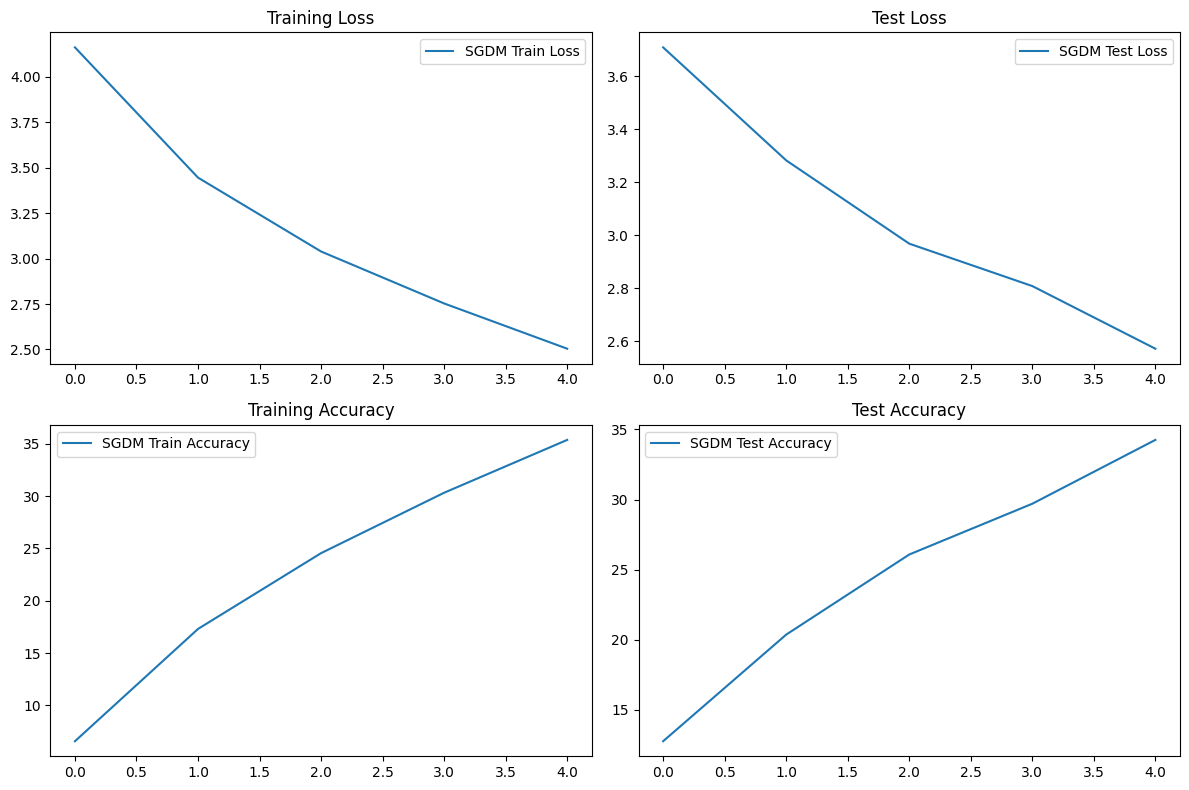

<Figure size 640x480 with 0 Axes>

In [ ]:
%run distributed-training.py --optimizer SGDM

Files already downloaded and verified
Files already downloaded and verified
--- Train with AdamW ---
Epoch 1/5, Loss: 3.8067, Train Acc: 11.34%, Test Acc: 19.12%
Epoch 2/5, Loss: 3.0943, Train Acc: 23.37%, Test Acc: 27.27%
Epoch 3/5, Loss: 2.7462, Train Acc: 30.39%, Test Acc: 31.69%
Epoch 4/5, Loss: 2.5068, Train Acc: 35.23%, Test Acc: 33.68%
Epoch 5/5, Loss: 2.3257, Train Acc: 39.17%, Test Acc: 35.76%


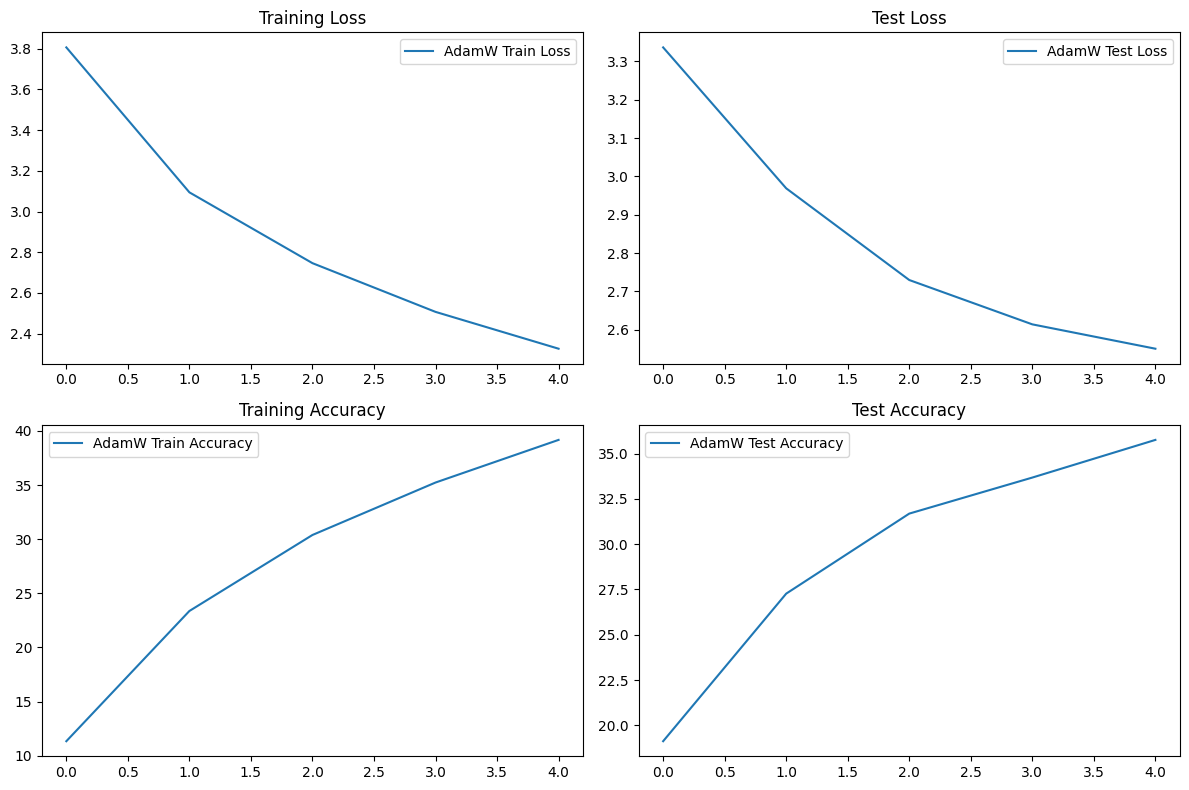

<Figure size 640x480 with 0 Axes>

In [ ]:
%run distributed-training.py --optimizer AdamW --lr 0.001

Files already downloaded and verified
Files already downloaded and verified
--- Train with LARS ---
Epoch 1/5, Loss: 4.6035, Train Acc: 1.33%, Test Acc: 1.57%
Epoch 2/5, Loss: 4.5927, Train Acc: 2.00%, Test Acc: 2.08%
Epoch 3/5, Loss: 4.5633, Train Acc: 2.14%, Test Acc: 1.97%
Epoch 4/5, Loss: 4.5151, Train Acc: 2.50%, Test Acc: 2.81%
Epoch 5/5, Loss: 4.4587, Train Acc: 3.53%, Test Acc: 4.21%


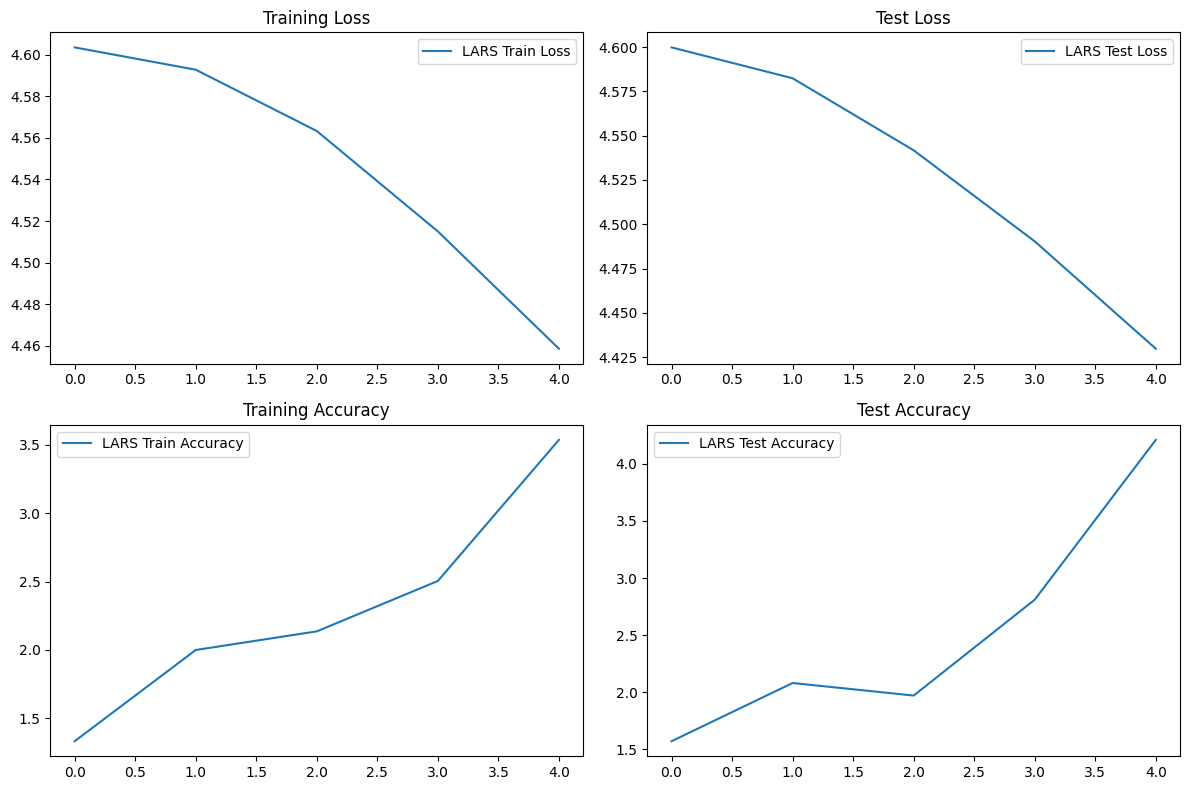

<Figure size 640x480 with 0 Axes>

In [ ]:
%run distributed-training.py --optimizer LARS

Files already downloaded and verified
Files already downloaded and verified
--- Train with LAMB ---
Epoch 1/5, Loss: 5.6251, Train Acc: 0.99%, Test Acc: 1.00%
Epoch 2/5, Loss: 4.6100, Train Acc: 0.95%, Test Acc: 1.00%
Epoch 3/5, Loss: 4.6092, Train Acc: 0.99%, Test Acc: 1.00%
Epoch 4/5, Loss: 4.6095, Train Acc: 0.86%, Test Acc: 1.00%
Epoch 5/5, Loss: 4.6089, Train Acc: 0.97%, Test Acc: 1.00%


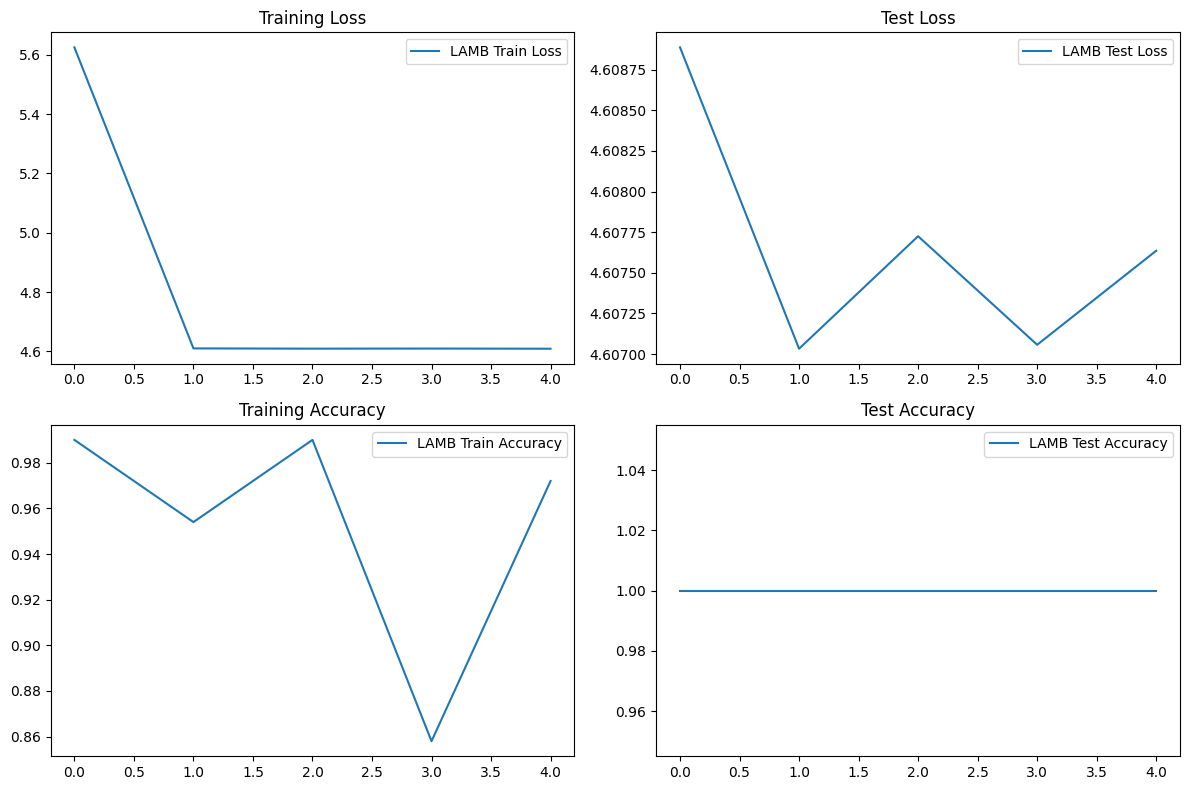

<Figure size 640x480 with 0 Axes>

In [ ]:
%run distributed-training.py --optimizer LAMB